In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import time
import gc
from scipy.stats import zscore
from scipy.signal import detrend
import copy
import sys
from scipy.integrate import simpson as simps
from scipy.ndimage import gaussian_filter1d

In [1]:
from pylab import *
import numpy as np

def field_field_coherence(x,y,dt, trl_indx = None):

    if trl_indx is not None:
        x = x[trl_indx,:]
        y = y[trl_indx,:]
#    print(x.shape)
        
    T = x.shape[0]    
    N = x.shape[1] 
    
    #generating arrays
    SYY = np.zeros(int(N/2+1))                            
    SXX = np.zeros(int(N/2+1))                        
    SYX = np.zeros(int(N/2+1), dtype=complex)           

    #loop over trials
    for k in range(T):                                

        yf = rfft((y[k,:]-np.mean(y[k,:])) *hanning(N))   #rfft of y 
        nf = rfft((x[k,:]-np.mean(x[k,:])) *hanning(N))   #rfft of x
        SYY = SYY + ( real( yf*conj(yf) ) )/T       #this appends power spectra (for y) for this trial
        SXX = SXX + ( real( nf*conj(nf) ) )/T           # ""  for x
        SYX = SYX + ( yf*conj(nf)   )/T     # "" xy

    coh = abs(SYX) / np.sqrt(SYY) / np.sqrt(SXX)            
    f = rfftfreq(N, dt)
    
    return coh, f   

In [4]:
def smooth_with_gaussian(data, sigma=2):
    return gaussian_filter1d(data, sigma=sigma, axis=1) 

def preprocess(data):
    zeros = np.zeros_like(data)
    mean = np.mean(data, axis = 0)
    std = np.std(data, axis = 0)
   
    std[std == 0] = 1  # Avoid division by zero by setting std to 1 where it is 0
    zeros = (data - mean) / std
    return zeros

def sample_plots(l_al, r_al, a_al, l_ar, r_ar, a_ar, width, height):
    #plotting some traces
    fig, ax = plt.subplots(1, 2, figsize=(width, height))
    ax[0].plot(np.mean(l_al, axis = 0), label = 'left')
    ax[0].plot(np.mean(r_al, axis = 0), label = 'right')
    ax[0].plot(np.mean(a_al, axis = 0), label = 'attention')
    ax[0].set_title('attention left - mean across trials')
    ax[1].plot(np.mean(l_ar, axis = 0), label = 'left')
    ax[1].plot(np.mean(r_ar, axis = 0), label = 'right')
    ax[1].plot(np.mean(a_ar, axis = 0), label = 'attention')
    ax[1].set_title('attention right - mean across trials')
    plt.legend()
    plt.show()

    plt.plot(np.mean(l_al, axis = 0), label = 'left input - attleft')
    plt.plot(-1 * np.mean(l_ar, axis = 0), label = 'negative of left input - attright')
    plt.title('mean of left attleft and negative of left attright')
    plt.legend()
    plt.show()

    fign, ax = plt.subplots(1, 2, figsize=(14, 7))
    ax[0].plot(l_al[0, :], label = 'left input - attleft')
    ax[0].plot(r_al[0, :], label = 'right input - attleft')
    ax[0].plot(a_al[0, :], label = 'attention - attleft')
    ax[0].set_title('trial 0 attleft data')
    ax[1].plot(l_ar[0, :], label = 'left input - attright')
    ax[1].plot(r_ar[0, :], label = 'right input - attright')
    ax[1].plot(a_ar[0, :], label = 'attention - attright')
    ax[1].set_title('trial 0 attright data')
    plt.legend()
    plt.show()


Dataset 1 loaded in 10.53 seconds


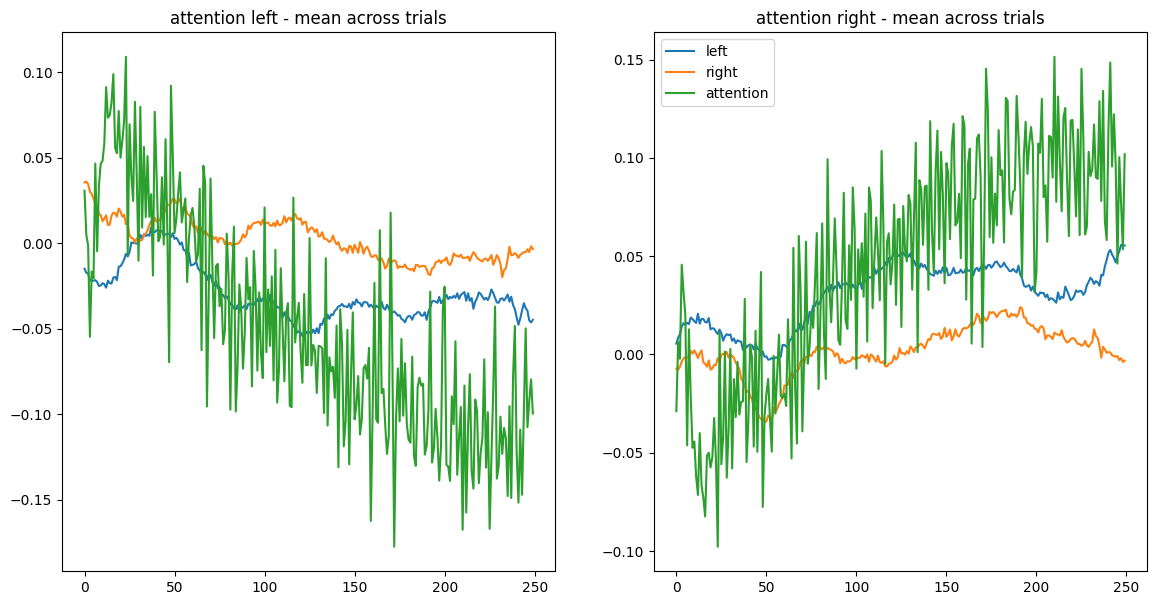

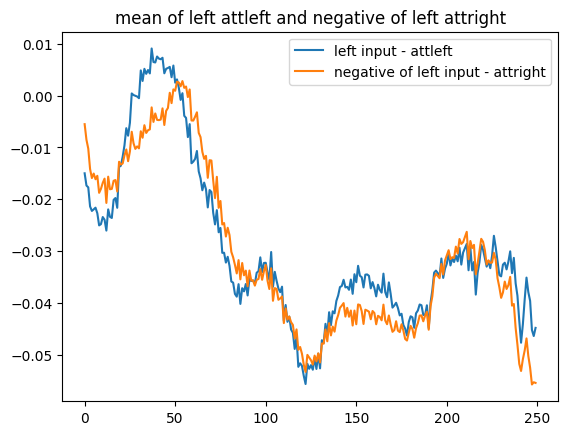

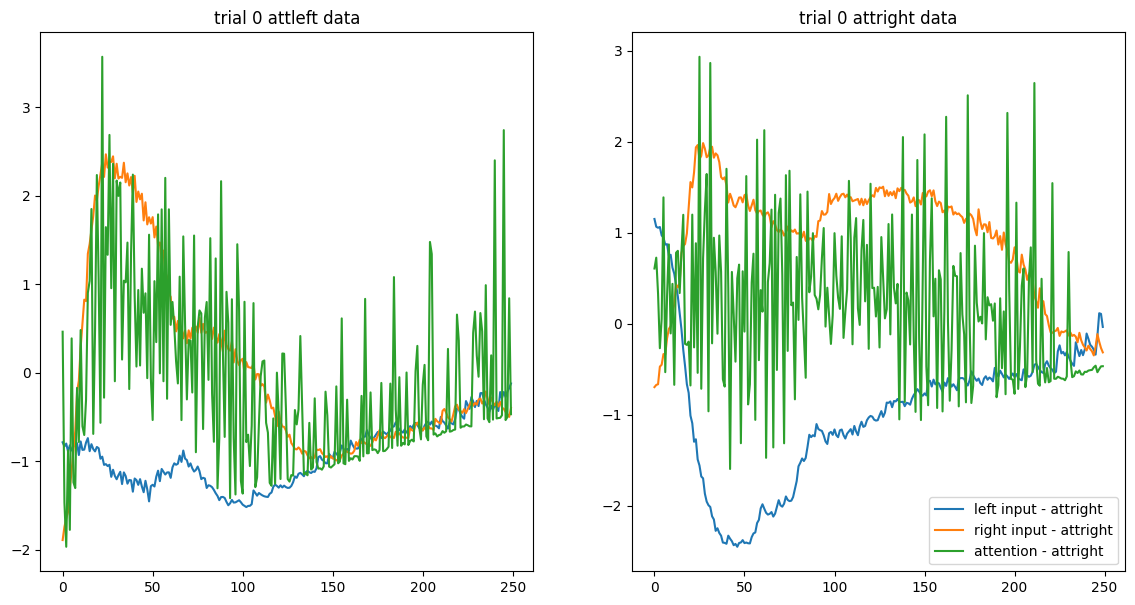

NaNs in left_attleft_coherence: False
Dataset 1 complete in 12.315227031707764
Dataset 2 loaded in 6.23 seconds


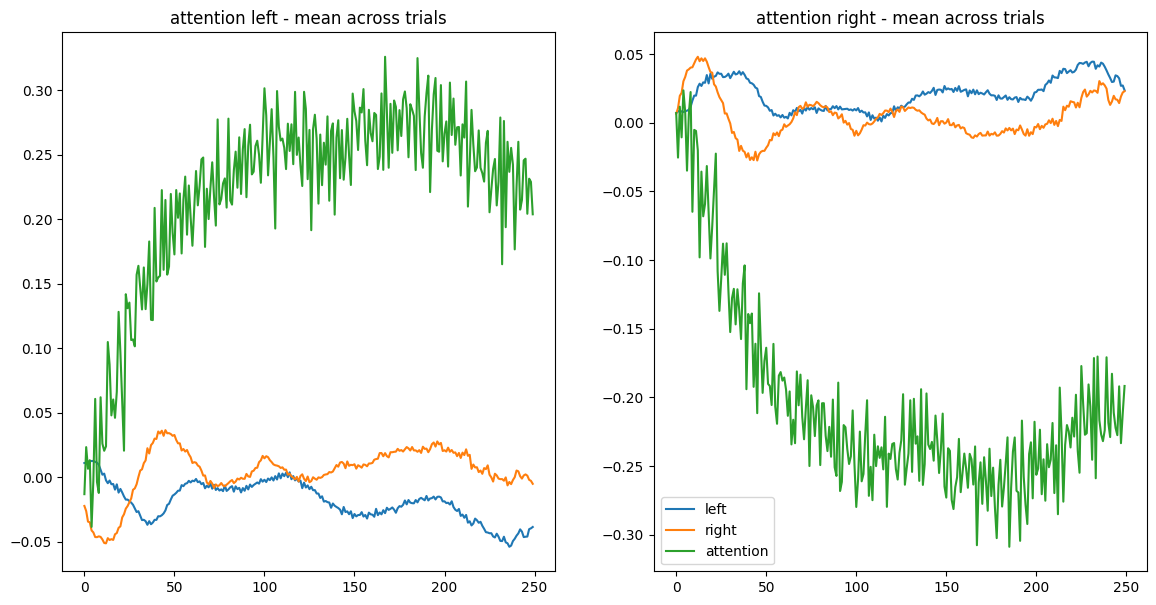

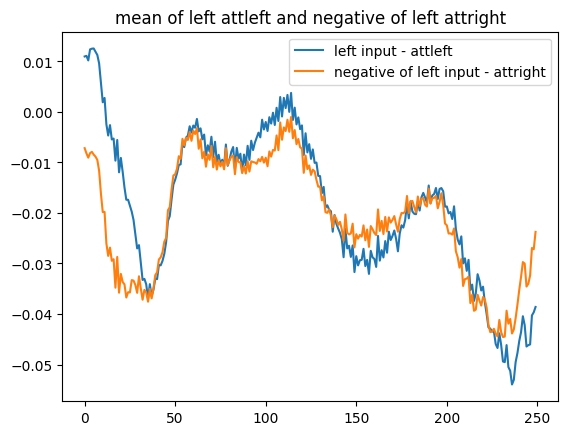

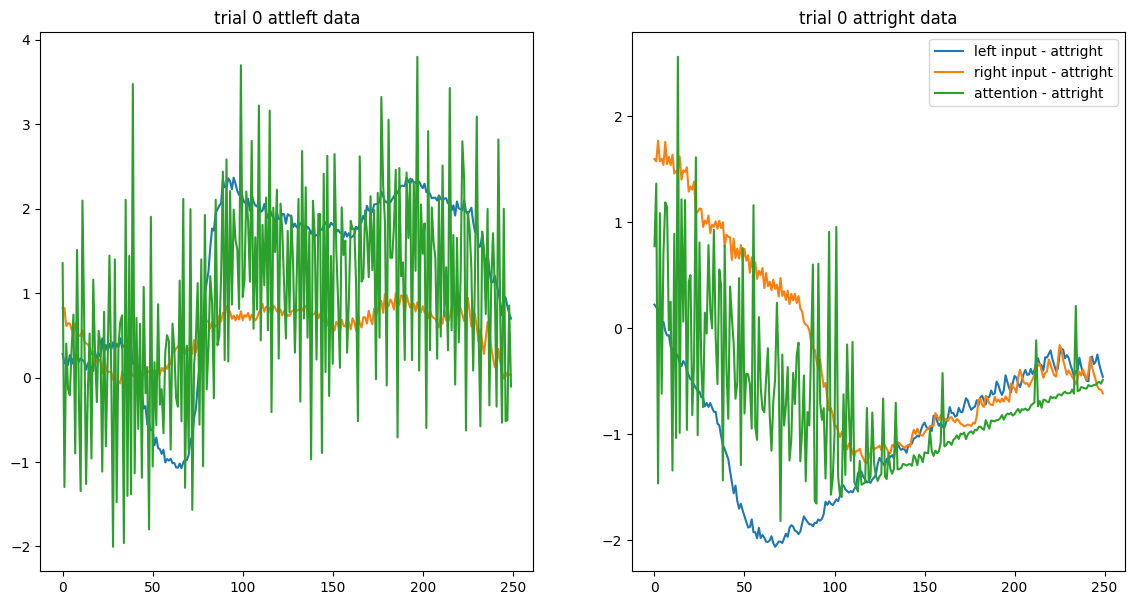

NaNs in left_attleft_coherence: False
Dataset 2 complete in 7.474679470062256
Dataset 4 loaded in 6.34 seconds


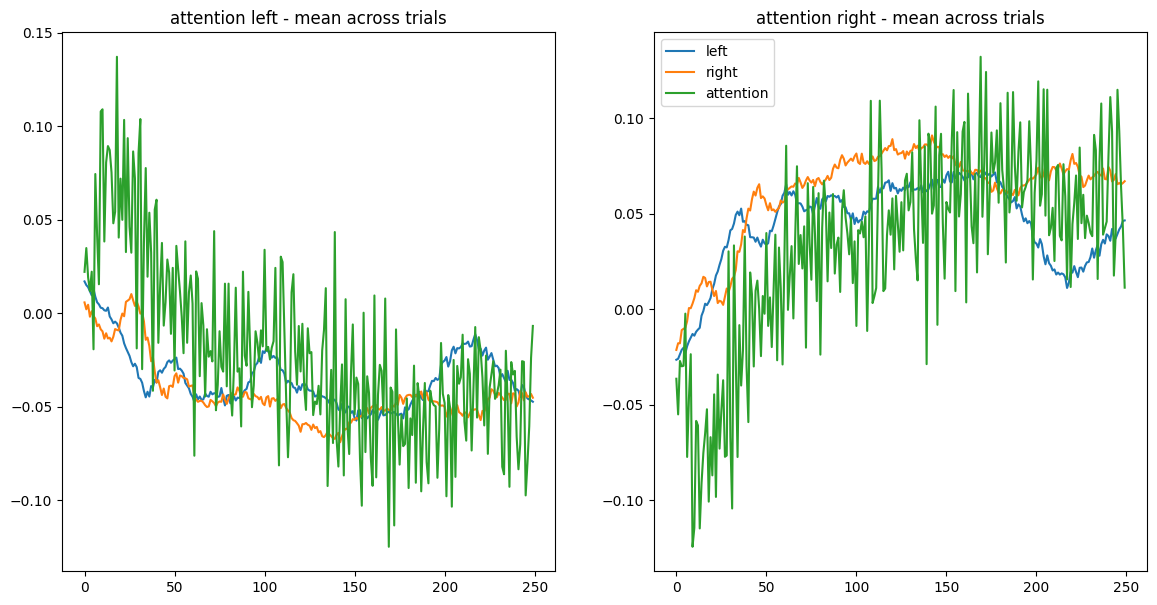

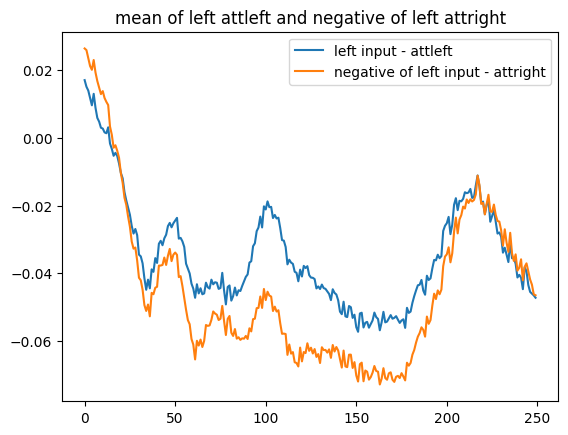

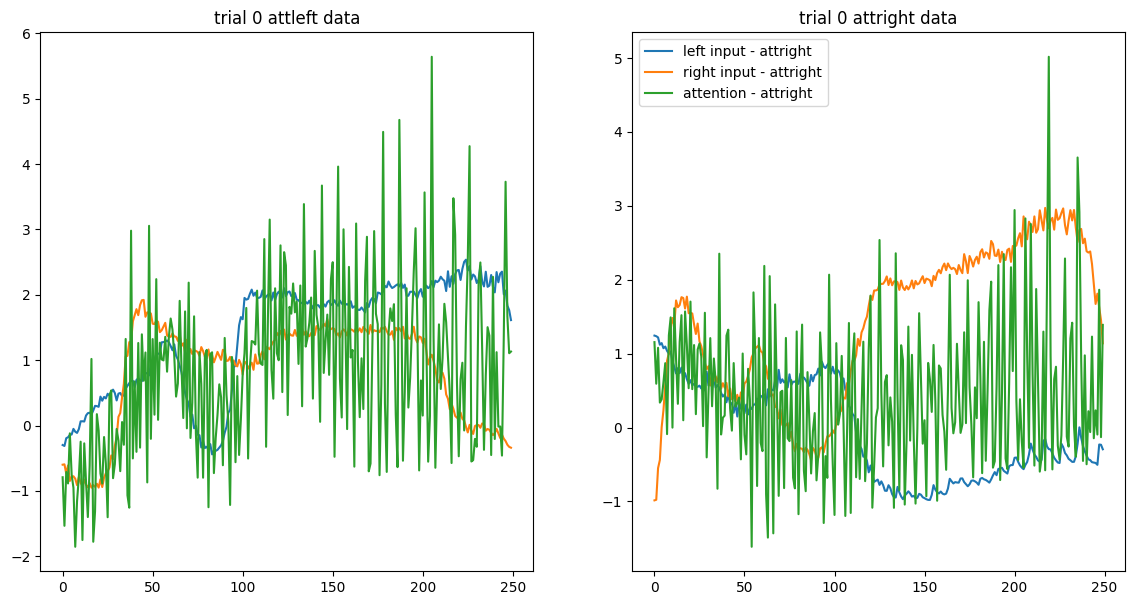

NaNs in left_attleft_coherence: False
Dataset 4 complete in 8.632481098175049
Dataset 8 loaded in 6.72 seconds


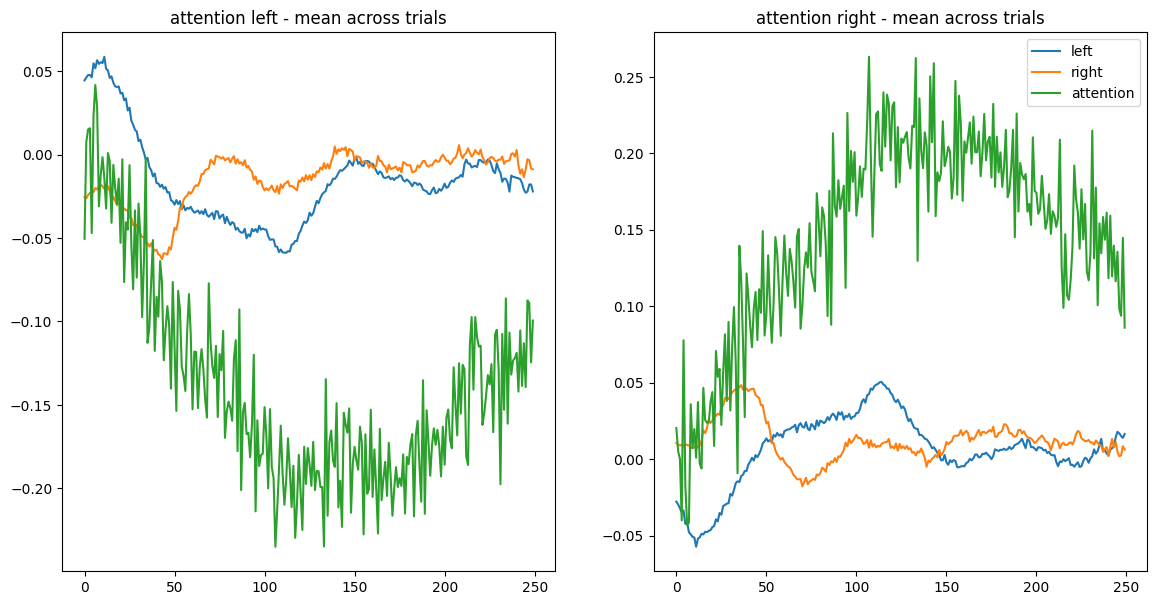

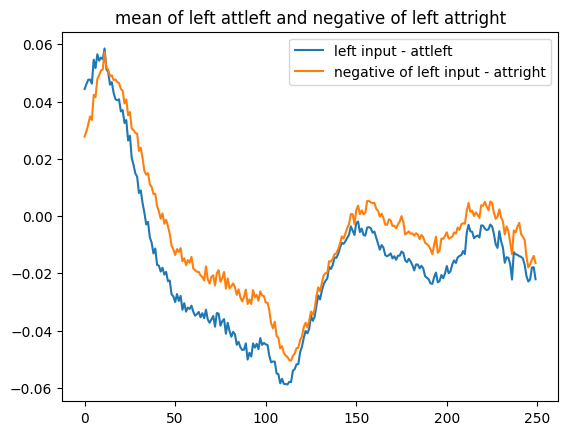

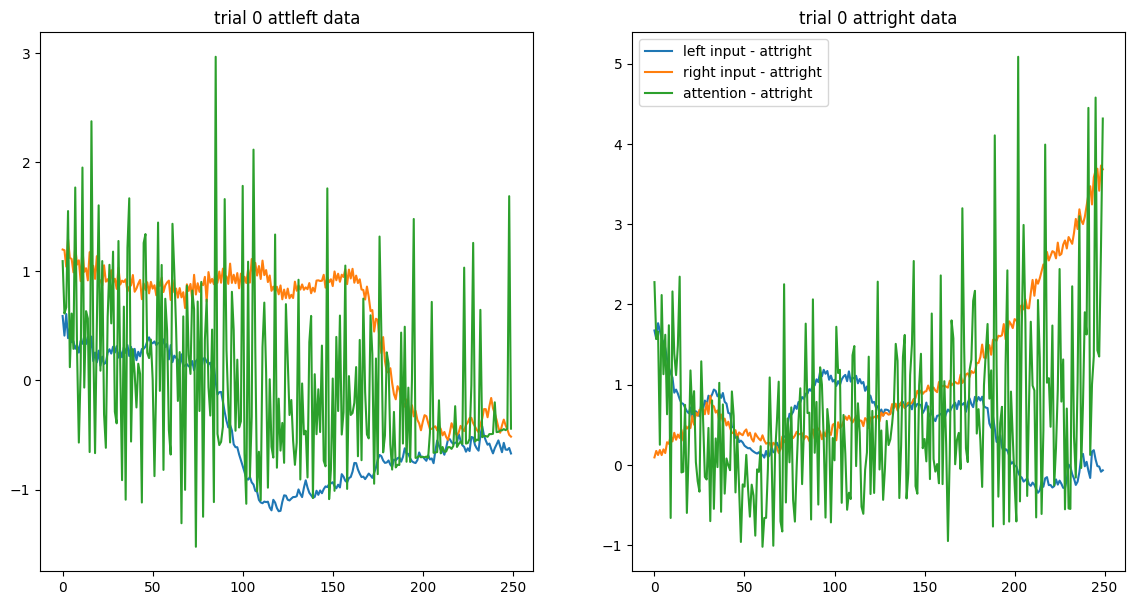

NaNs in left_attleft_coherence: False
Dataset 8 complete in 8.233967065811157
Dataset 14 loaded in 6.66 seconds


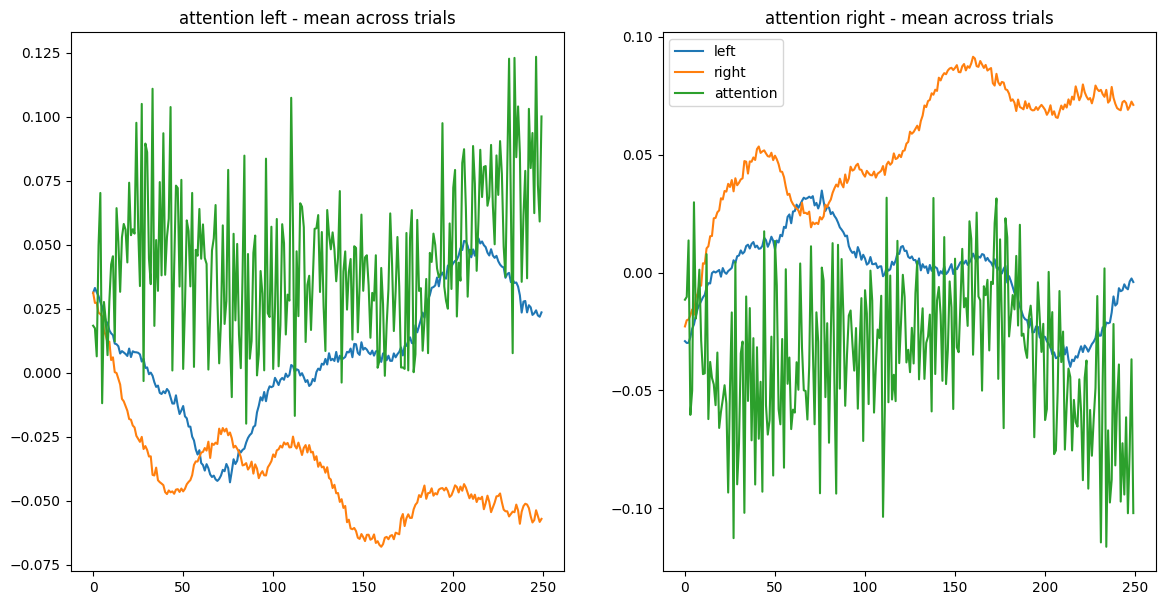

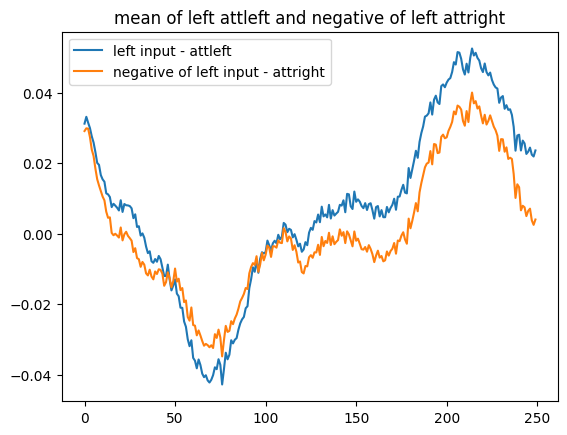

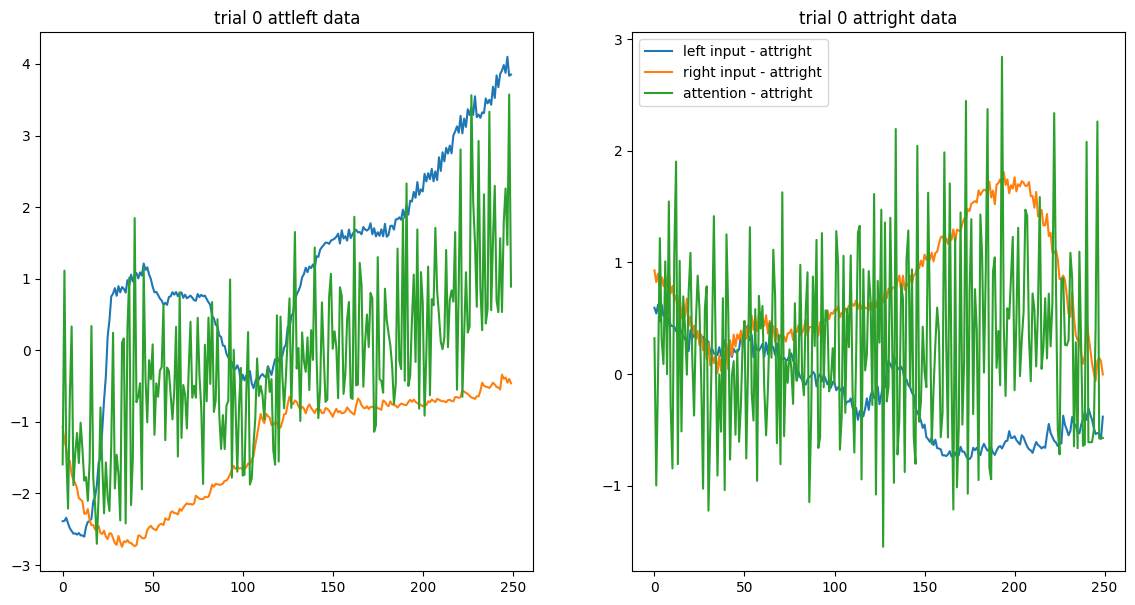

NaNs in left_attleft_coherence: False
Dataset 14 complete in 8.817245483398438
Dataset 15 loaded in 5.78 seconds


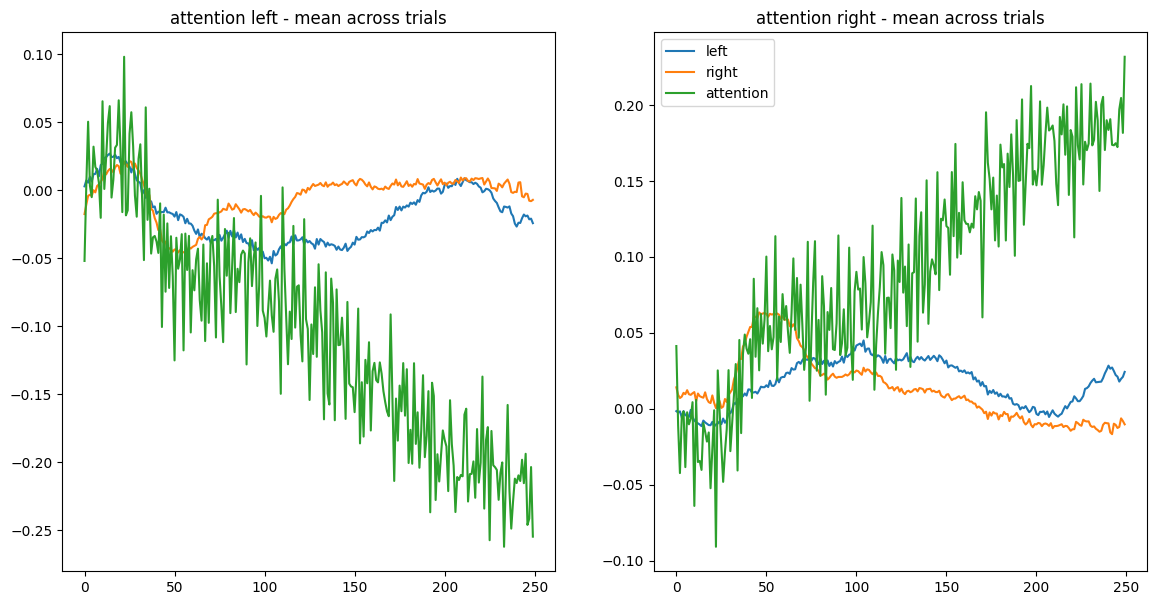

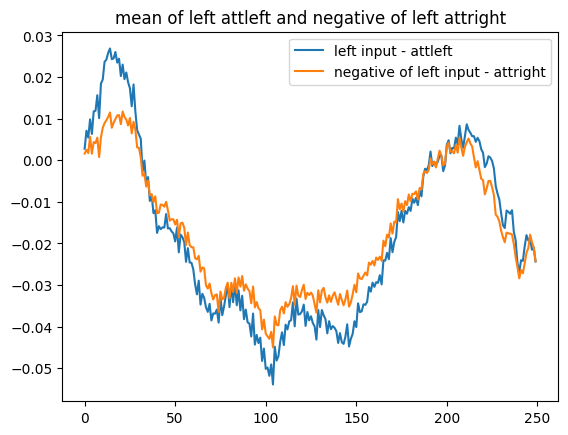

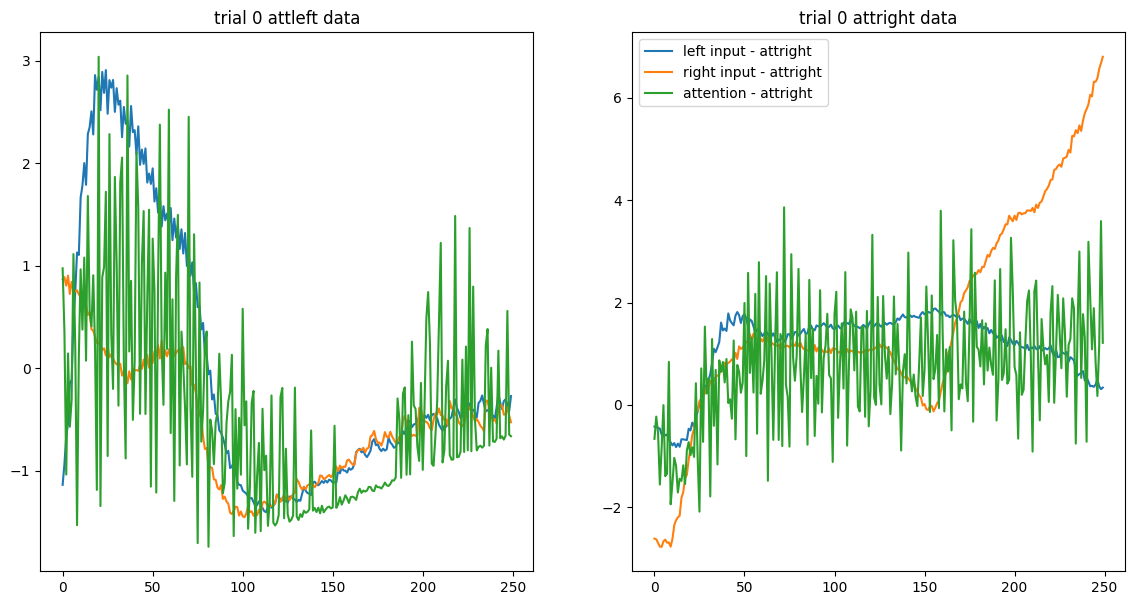

NaNs in left_attleft_coherence: False
Dataset 15 complete in 7.41036057472229
Dataset 20 loaded in 6.34 seconds


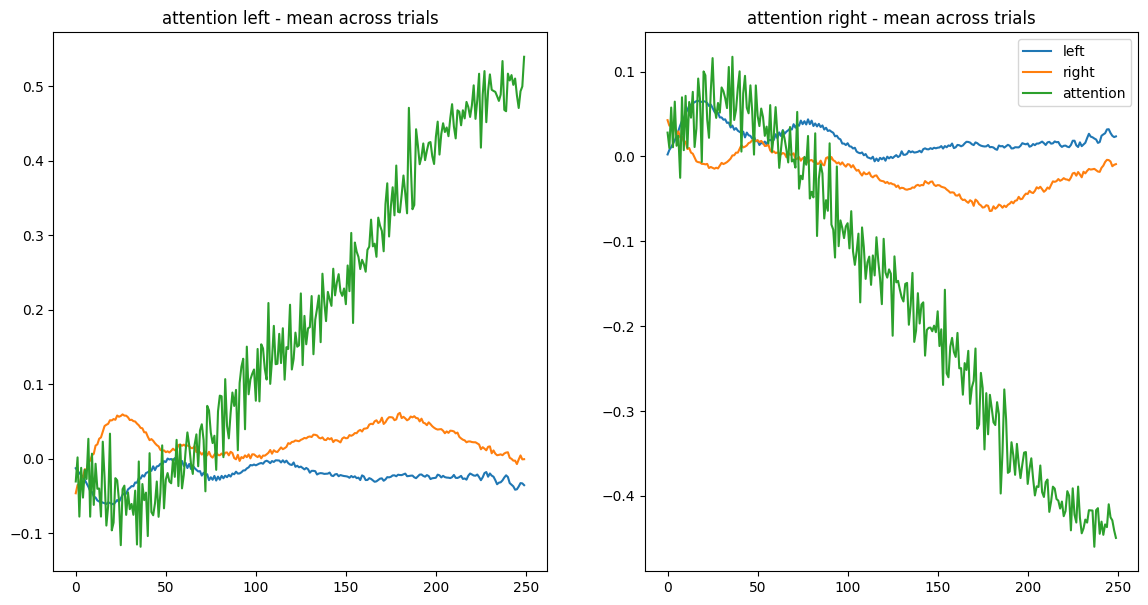

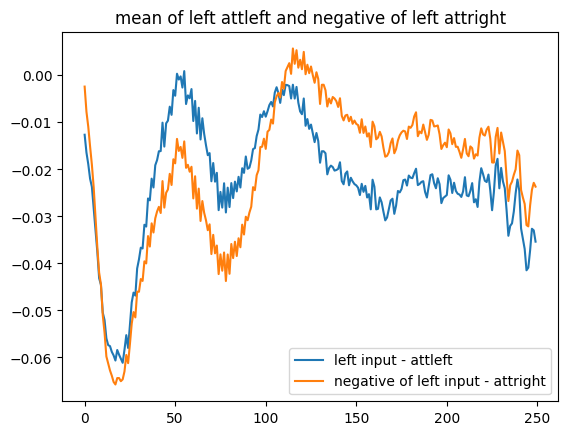

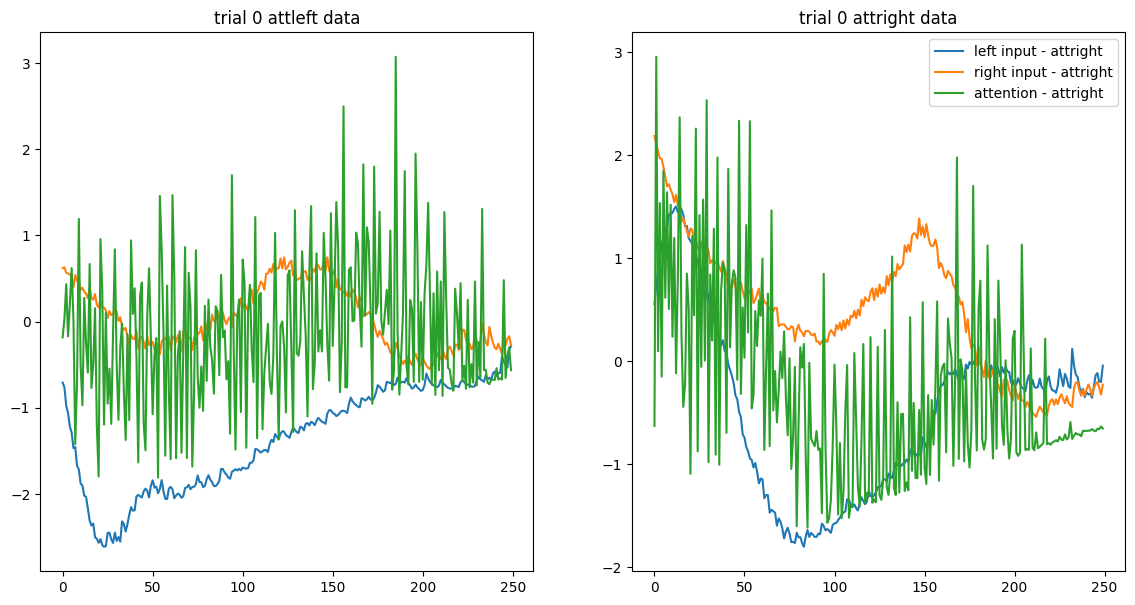

NaNs in left_attleft_coherence: False
Dataset 20 complete in 8.154191017150879
Dataset 23 loaded in 5.51 seconds


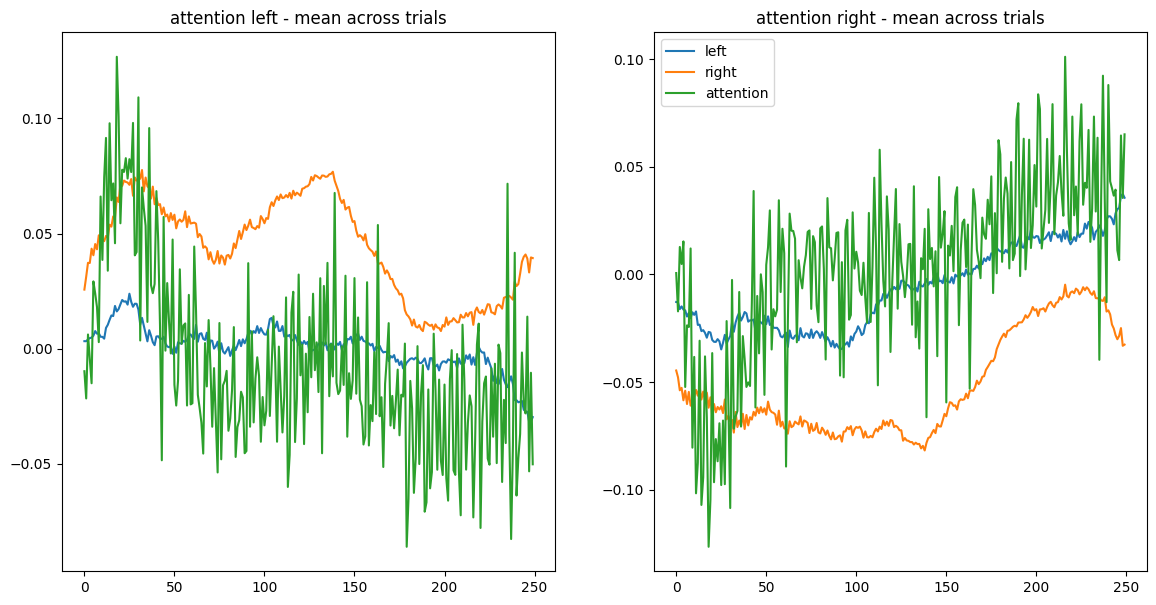

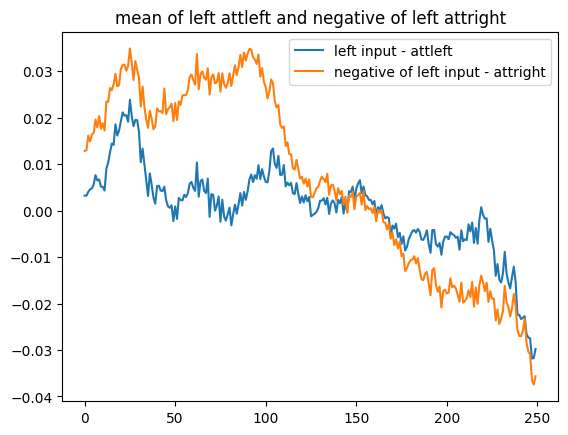

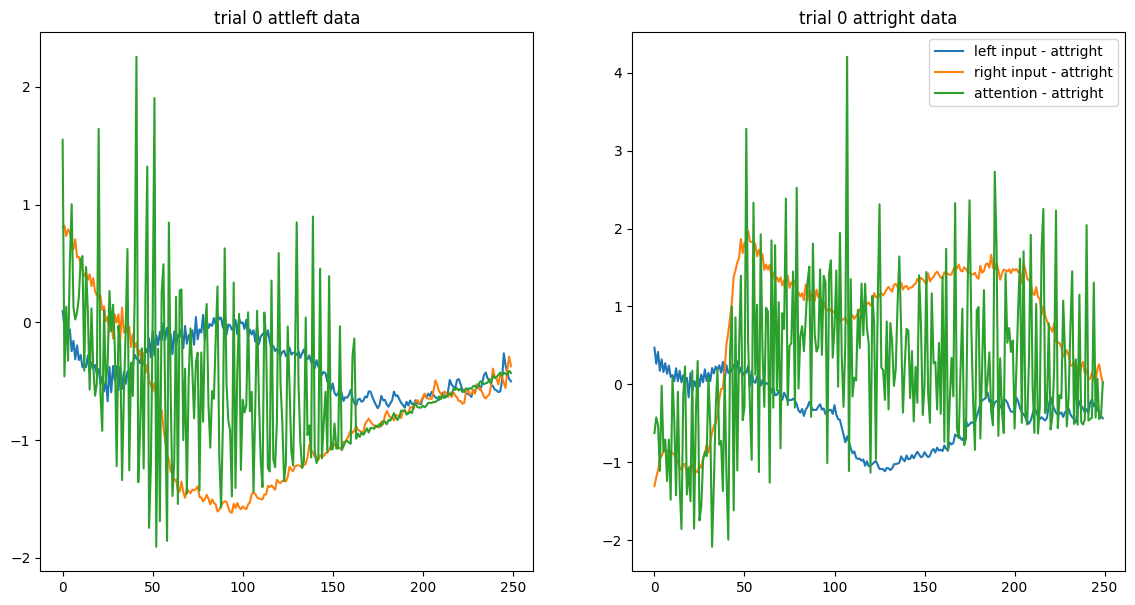

NaNs in left_attleft_coherence: False
Dataset 23 complete in 7.087530612945557
total time elapsed = 68.13396263122559
{'dataset_1': {'delta': {'left_attleft': np.float64(1.213387280423161), 'right_attleft': np.float64(1.1623575379634705), 'left_attright': np.float64(1.1004712720678458), 'right_attright': np.float64(1.1199372722561614)}, 'theta': {'left_attleft': np.float64(1.1895678164747872), 'right_attleft': np.float64(1.0571619491542608), 'left_attright': np.float64(0.9736517294398221), 'right_attright': np.float64(1.0643193481590791)}, 'alpha': {'left_attleft': np.float64(1.7105122099124037), 'right_attleft': np.float64(1.9525664025092437), 'left_attright': np.float64(1.5813315634883103), 'right_attright': np.float64(2.3556074493891854)}, 'beta': {'left_attleft': np.float64(3.0729333557915686), 'right_attleft': np.float64(4.851297923276685), 'left_attright': np.float64(3.0694990996356855), 'right_attright': np.float64(4.675655420933925)}, 'gamma': {'left_attleft': np.float64(3.4510

In [6]:

file_numbers = [1, 2, 4, 8, 14, 15, 20, 23]
dt = 0.002
bands = ['delta', 'theta', 'alpha', 'beta', 'gamma']   #for coherence I have looked at the mean valuee for these bands
freq_ranges = [(0, 4), (4, 8), (8, 13), (13, 30), (30, 80)]  #freq ranges

structure = {f'dataset_{file_number}': {f'{band}': {
    'left_attleft': [],
    'right_attleft': [],
    'left_attright': [],
    'right_attright': []
} for band in bands} for file_number in file_numbers} 

coherence_results = copy.deepcopy(structure)
coherence_results_means = copy.deepcopy(structure)

total_time = time.time()
for file_number in  file_numbers:
    file_total = time.time()
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    load_data_start_time = time.time()
    data = pickle.load(open(file_path, 'rb'))
    elapsed_time = time.time() - load_data_start_time
    print(f"Dataset {file_number} loaded in {elapsed_time:.2f} seconds")

    attention_labels = data['label_attend'][0]
    label_left = data['label_left'][0]
    label_right = data['label_right'][0]
    attend_01 = data['attend'][0]
    omitted = data["omit"][0]
    relevant = np.where(omitted == 0)[0]    #indices of agg where not omitted
   
    left_input_LFP = preprocess(data['LFP'][0][0][relevant, 100:350])
    right_input_LFP = preprocess(data['LFP'][0][1][relevant, 100:350])
    attention_LFP = preprocess(data['LFP_rec'][0][2][relevant, 100:350])

    left_indices_agg = np.where((omitted == 0) & (attend_01 == 0) & (label_left != label_right))[0]  #indices of agg where left 
    _, left_indices, _ = np.intersect1d(relevant, left_indices_agg, return_indices = True)  #indices for relevant processed data where attention left
    right_indices_agg = np.where((omitted ==0) & (attend_01 == 1) & (label_left != label_right))[0]
    _, right_indices, _ = np.intersect1d(relevant, right_indices_agg, return_indices = True)

    
    left_input_LFP_attleft = left_input_LFP[left_indices, :]   #data for attention left
    right_input_LFP_attleft = right_input_LFP[left_indices, :]
    attention_LFP_attleft = attention_LFP[left_indices, :]

    left_input_LFP_attright = left_input_LFP[right_indices, :]   #data for attention right
    right_input_LFP_attright = right_input_LFP[right_indices, :]
    attention_LFP_attright = attention_LFP[right_indices, :]
    
    #some plots
    sample_plots(left_input_LFP_attleft, right_input_LFP_attleft,
                  attention_LFP_attleft, left_input_LFP_attright,
                    right_input_LFP_attright, attention_LFP_attright, 14, 7)

    #----------------calculating coherence --------------------------------
    left_attleft_coherence, freq = field_field_coherence(
        left_input_LFP_attleft, attention_LFP_attleft, dt)
    right_attleft_coherence, freq = field_field_coherence(
        right_input_LFP_attleft, attention_LFP_attleft, dt)
    left_attright_coherence, freq = field_field_coherence(
        left_input_LFP_attright, attention_LFP_attright, dt)
    right_attright_coherence, freq = field_field_coherence(
        right_input_LFP_attright, attention_LFP_attright, dt)
    
    print("NaNs in left_attleft_coherence:", np.isnan(left_attleft_coherence).any())

    
    # plt.plot(freq, left_attleft_coherence, label = 'left attleft')
    # plt.title('left attleft coherence')
    # plt.show()


    for band, (f_min, f_max) in zip(bands, freq_ranges):
        band_idx = (freq >= f_min) & (freq < f_max)
        coherence_results[f'dataset_{file_number}'][band]['left_attleft'] = simps(left_attleft_coherence[band_idx], freq[band_idx])
        coherence_results[f'dataset_{file_number}'][band]['right_attleft'] = simps(right_attleft_coherence[band_idx], freq[band_idx])
        coherence_results[f'dataset_{file_number}'][band]['left_attright'] = simps(left_attright_coherence[band_idx], freq[band_idx])
        coherence_results[f'dataset_{file_number}'][band]['right_attright'] = simps(right_attright_coherence[band_idx], freq[band_idx])

    for band, (f_min, f_max) in zip(bands, freq_ranges):
        band_idx = (freq >= f_min) & (freq < f_max)
        coherence_results_means[f'dataset_{file_number}'][band]['left_attleft'] = np.mean(left_attleft_coherence[band_idx])
        coherence_results_means[f'dataset_{file_number}'][band]['right_attleft'] = np.mean(right_attleft_coherence[band_idx])
        coherence_results_means[f'dataset_{file_number}'][band]['left_attright'] = np.mean(left_attright_coherence[band_idx])
        coherence_results_means[f'dataset_{file_number}'][band]['right_attright'] = np.mean(right_attright_coherence[band_idx])


    del left_input_LFP_attleft, right_input_LFP_attleft, attention_LFP_attleft, left_input_LFP_attright, right_input_LFP_attright, attention_LFP_attright
    gc.collect()
    del(data)
    gc.collect()
    print(f'Dataset {file_number} complete in', time.time() - file_total)

print('total time elapsed =', time.time() - total_time)
print(coherence_results)


[np.float64(1.166662276339661), np.float64(1.1314144050156583), np.float64(1.2977573066345032), np.float64(1.1168664998651692), np.float64(1.1988020711409297), np.float64(1.351400573845273), np.float64(0.9889979808634607), np.float64(1.1286920988922464), np.float64(1.177579567581744), np.float64(1.2803540480420632), np.float64(0.798344249324092), np.float64(1.253365578748446), np.float64(0.8301582481001439), np.float64(1.1345754771513317), np.float64(1.2410426840836533), np.float64(1.1843619568730968)]
[np.float64(1.146802929328297), np.float64(1.07341062215635), np.float64(1.2976879827404844), np.float64(1.0525240739142618), np.float64(1.2279831337359943), np.float64(1.2896470823393693), np.float64(1.0166218545918473), np.float64(1.0533845168812725), np.float64(1.147572518885755), np.float64(1.2390515055812665), np.float64(0.7341734355941725), np.float64(1.119781125846868), np.float64(0.8430195823594772), np.float64(1.0793381494495333), np.float64(1.1719565791445437), np.float64(1.154

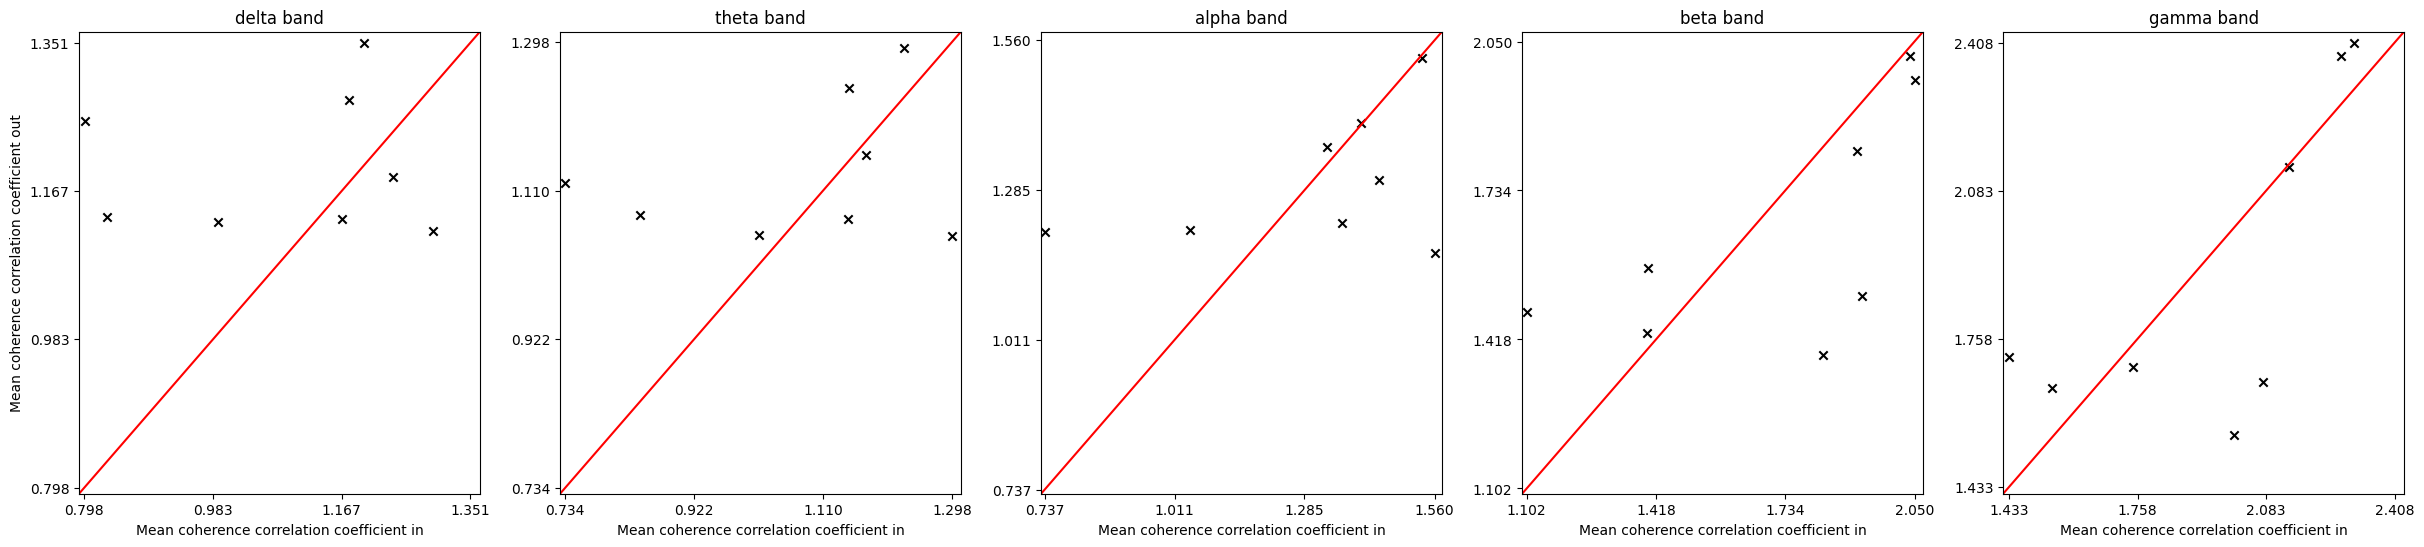

In [7]:
coherence_in = {f'{band}': [] for band in bands}
coherence_out = {f'{band}': [] for band in bands}

for file_number in file_numbers:
    values = []
    errors = []
    for band in bands:
        for condition in ['left_attleft', 'right_attright']:
            values.append(coherence_results[f'dataset_{file_number}'][band][condition])
        coherence_in[f'{band}'].append(np.mean(values))

    values = []
    errors = []
    for band in bands:
        for condition in ['left_attright', 'right_attleft']:
            values.append(coherence_results[f'dataset_{file_number}'][band][condition])
        coherence_out[f'{band}'].append(np.mean(values))
    
    
max_values = {f'{band}': [] for band in bands}
min_values = {f'{band}': [] for band in bands}

idx = np.arange(len(file_numbers))
for band in bands:
    values = []
    for f in idx:
        values.append(coherence_in[f'{band}'][f])
        values.append(coherence_out[f'{band}'][f])
    print(values)
    max_values[f'{band}'].append(max(values))
    min_values[f'{band}'].append(min(values))

print(max_values)

fig, axs = plt.subplots(1,5, figsize=(30, 6))
for i, band in enumerate(bands):
    axs[i].scatter(coherence_in[f'{band}'], coherence_out[f'{band}'], marker='x', color='k')
    axs[i].plot([0, 1], [0, 1], transform=axs[i].transAxes, color='r')
    axs[i].set_xlim(min_values[f'{band}'][0]*(0.99), max_values[f'{band}'][0]*(1.01))
    axs[i].set_ylim(min_values[f'{band}'][0]*(0.99), max_values[f'{band}'][0]*(1.01))
    axs[i].set_xticks(np.round(np.linspace(min_values[f'{band}'][0],max_values[f'{band}'][0], 4), 3))
    axs[i].set_yticks(np.round(np.linspace(min_values[f'{band}'][0],max_values[f'{band}'][0], 4), 3))
    axs[i].set_xlabel('Mean coherence correlation coefficient in')
    axs[0].set_ylabel('Mean coherence correlation coefficient out')
    axs[i].set_title(f'{band} band')
plt.show()


[np.float64(0.5833311381698305), np.float64(0.5657072025078291), np.float64(0.6488786533172516), np.float64(0.5584332499325846), np.float64(0.5994010355704649), np.float64(0.6757002869226365), np.float64(0.49449899043173035), np.float64(0.5643460494461232), np.float64(0.588789783790872), np.float64(0.6401770240210316), np.float64(0.399172124662046), np.float64(0.626682789374223), np.float64(0.41507912405007197), np.float64(0.5672877385756658), np.float64(0.6205213420418266), np.float64(0.5921809784365484)]
[np.float64(0.5734014646641485), np.float64(0.536705311078175), np.float64(0.6488439913702422), np.float64(0.5262620369571309), np.float64(0.6139915668679972), np.float64(0.6448235411696847), np.float64(0.5083109272959236), np.float64(0.5266922584406363), np.float64(0.5737862594428775), np.float64(0.6195257527906333), np.float64(0.36708671779708624), np.float64(0.559890562923434), np.float64(0.4215097911797386), np.float64(0.5396690747247667), np.float64(0.5859782895722718), np.float

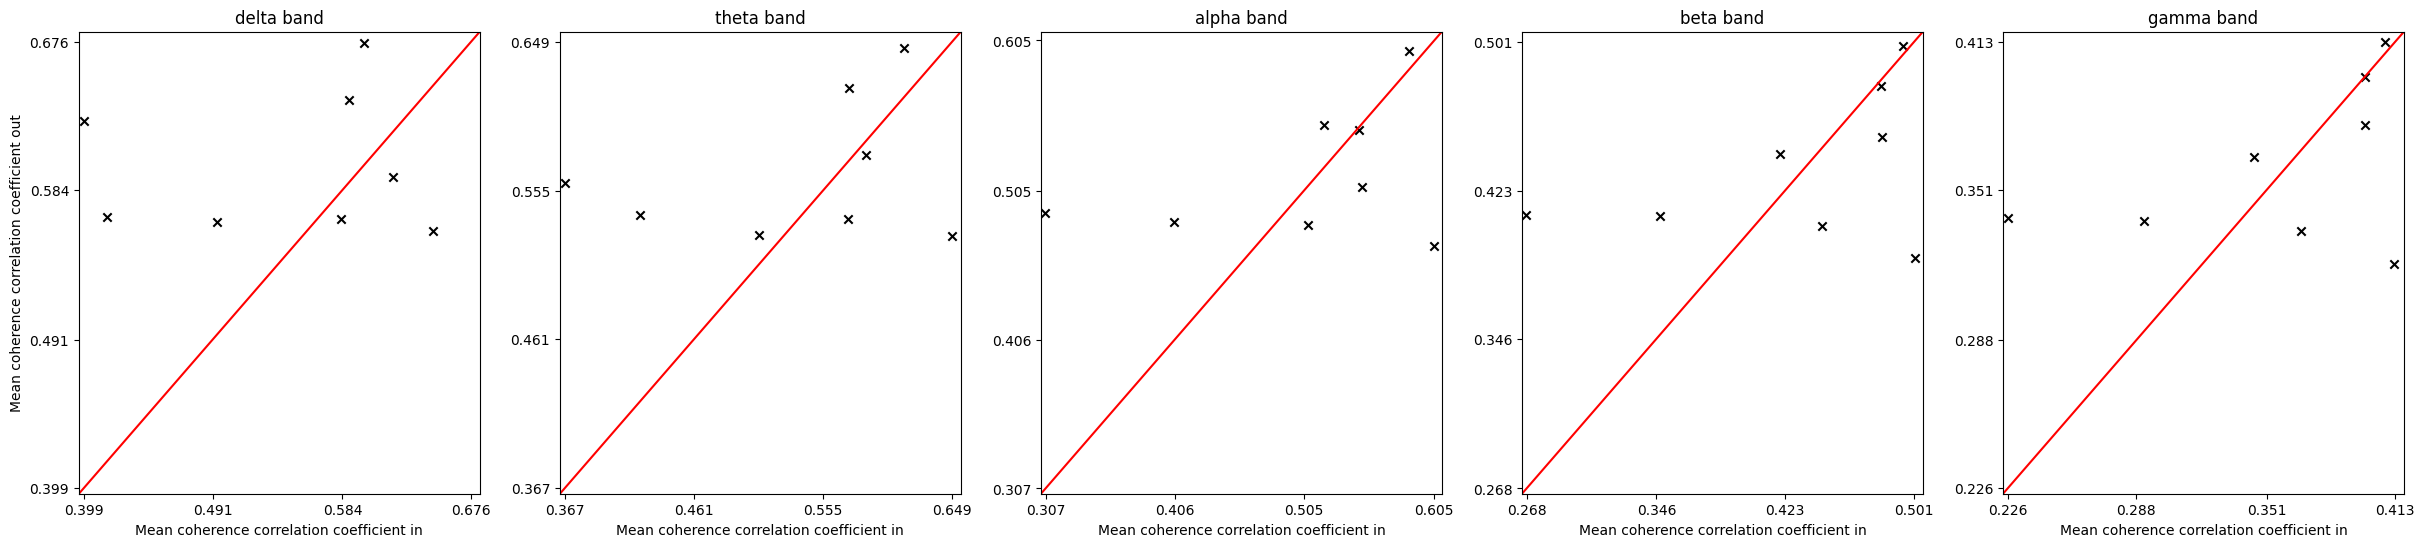

In [8]:
coherence_in = {f'{band}': [] for band in bands}
coherence_out = {f'{band}': [] for band in bands}


for file_number in file_numbers:
    values = []
    errors = []
    for band in bands:
        for condition in ['left_attleft', 'right_attright']:
            values.append(coherence_results_means[f'dataset_{file_number}'][band][condition])
        coherence_in[f'{band}'].append(np.mean(values))



    values = []
    errors = []
    for band in bands:
        for condition in ['left_attright', 'right_attleft']:
            values.append(coherence_results_means[f'dataset_{file_number}'][band][condition])
        coherence_out[f'{band}'].append(np.mean(values))
    
max_values = {f'{band}': [] for band in bands}
min_values = {f'{band}': [] for band in bands}

idx = np.arange(len(file_numbers))
for band in bands:
    values = []
    for f in idx:
        values.append(coherence_in[f'{band}'][f])
        values.append(coherence_out[f'{band}'][f])
    print(values)
    max_values[f'{band}'].append(max(values))
    min_values[f'{band}'].append(min(values))

print(max_values)

fig, axs = plt.subplots(1,5, figsize=(30, 6))
for i, band in enumerate(bands):
    axs[i].scatter(coherence_in[f'{band}'], coherence_out[f'{band}'], marker='x', color='k')
    axs[i].plot([0, 1], [0, 1], transform=axs[i].transAxes, color='r')
    axs[i].set_xlim(min_values[f'{band}'][0]*(0.99), max_values[f'{band}'][0]*(1.01))
    axs[i].set_ylim(min_values[f'{band}'][0]*(0.99), max_values[f'{band}'][0]*(1.01))
    axs[i].set_xticks(np.round(np.linspace(min_values[f'{band}'][0],max_values[f'{band}'][0], 4), 3))
    axs[i].set_yticks(np.round(np.linspace(min_values[f'{band}'][0],max_values[f'{band}'][0], 4), 3))
    axs[i].set_xlabel('Mean coherence correlation coefficient in')
    axs[0].set_ylabel('Mean coherence correlation coefficient out')
    axs[i].set_title(f'{band} band')
plt.show()
